## Observations

In [1]:
using LinearAlgebra
using Plots

In [2]:
include("../rollout.jl")
include("../testfns.jl")

ConstantTestFunction (generic function with 2 methods)

In [3]:
function sample_random_matrix(xmin, xmax, d, n)
    matrix = zeros(d, n)
    for i in 1:d
        for j in 1:n
            matrix[i, j] = xmin + (xmax - xmin) * rand()
        end
    end
    return matrix
end

sample_random_matrix (generic function with 1 method)

In [4]:
BUDGET = 1

1

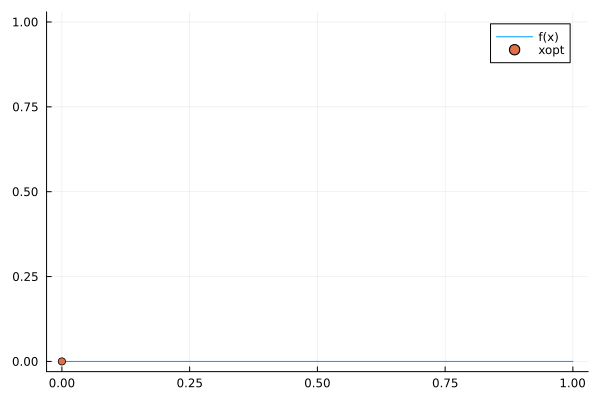

In [5]:
testfn = ConstantTestFunction(0., lbs=[0.], ubs=[1.])
tplot(testfn)

In [240]:
n, h, σn2 = 1, 0, 1e-6
MC_SAMPLES = 100
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 25, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [.25]
ψ = kernel_scale(
    kernel_matern52,
    [5., θ...]
)
# ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 64
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [241]:
function filter_values_by_epsilon(observation, domain, epsilon)
    filtered_values = vec([])

    for obs_value in domain
        abs_dist = abs.(obs_value .- observation)
        if all(abs_dist .> epsilon)
            push!(filtered_values, obs_value)
        end
    end

    filtered_values = hcat([x;; for x in filtered_values]...)
    return filtered_values
end

# Example usage
observation = [0.1, 0.2]
domain = 0:0.01:1
epsilon = .02

filtered_observation = filter_values_by_epsilon(observation, domain, epsilon)
filtered_observation

1×93 Matrix{Float64}:
 0.0  0.01  0.02  0.03  0.04  0.05  …  0.95  0.96  0.97  0.98  0.99  1.0

In [242]:
X = [.05;; .95;;]
δX = rand(size(X)...)
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)
domain = xmin:.01:xmax
epsilon = .03
domain = filter_values_by_epsilon(X, domain, epsilon)
# domain = filter(x -> !(x in X), domain)
ex = zeros(length(domain))
stdx = zeros(length(domain))
dex = zeros(length(domain))
dstdx = zeros(length(domain))
αxs, ∇αxs = zeros(MC_SAMPLES), zeros(MC_SAMPLES)

T = nothing
print("Beginning Experiment\nProgress Bar: ")
for (i, x) in enumerate(domain)
# for (i, x) in enumerate([.5])
    print("|")
    x0 = [x]

    # Rollout Trajectory
    for j in 1:MC_SAMPLES
        T = Trajectory(Base.deepcopy(sur), x0, h)
        rollout!(T, lbs, ubs; xstarts=xstarts, rnstream=rns[j,:,:])
        αxs[j] = α(T)
        ∇αxs[j] = first(∇α(T))
    end

    sx = sur(x0)
    μ = sum(αxs) / MC_SAMPLES
    dμ = sum(∇αxs) / MC_SAMPLES
    ex[i] = μ + sx.EI
    dex[i] = dμ + first(sx.∇EI)
    stdx[i] = sqrt(sum((αxs .- μ) .^ 2) / (MC_SAMPLES - 1))
    dstdx[i] = sqrt(sum((∇αxs .- dμ) .^ 2) / (MC_SAMPLES - 1))
end

# ex = normalize(ex)
# dex = normalize(dex);

Beginning Experiment
Progress Bar: |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

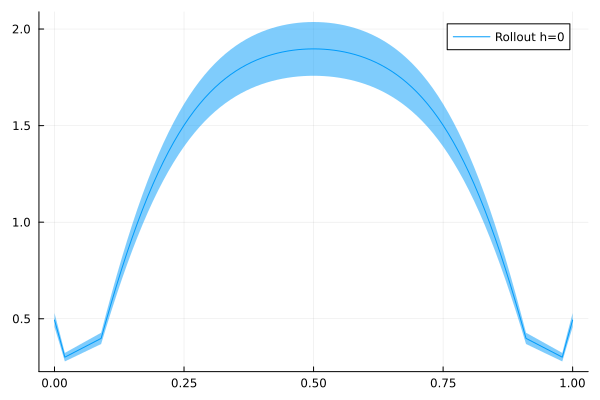

In [243]:
plot(
    domain[1,:],
    ex,
    label="Rollout h=$h",
    ribbons=stdx / sqrt(MC_SAMPLES)
)
# plot!(domain, [sur([x]).EI for x in domain])

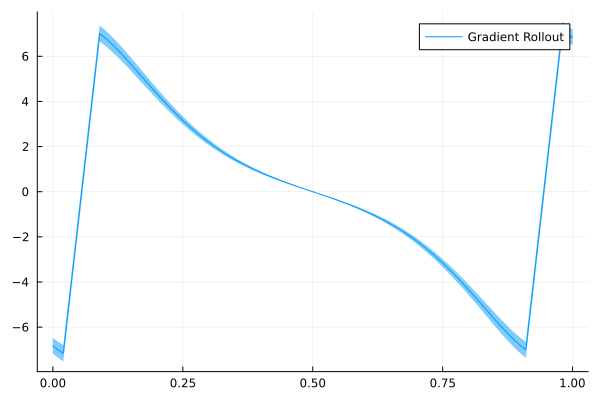

In [245]:
# plot(domain, [first(sur([x]).∇EI) for x in domain])
plot(
    domain[1,:],
    dex,
    label="Gradient Rollout",
    ribbons=dstdx / sqrt(MC_SAMPLES)
)

In [173]:
# Perturbations sufficiently close to known locations blow up.
Ts[1][1].δfs.X

1×4 Matrix{Float64}:
 0.0  0.0  0.182888  -3.29816